# RealNVP - 2D

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
def sample_data():
    count = 100000
    rand = np.random.RandomState(0)
    a = [[-1.5, 2.5]] + rand.randn(100000 - 2 * count // 3, 2) * 0.2
    b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
    -np.sin(np.linspace(0, np.pi, count // 3))]
    c += rand.randn(*c.shape) * 0.2
    data_x = np.concatenate([a, b, c], axis=0)
    data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
    perm = rand.permutation(len(data_x))
    return data_x[perm], data_y[perm]

## sample data

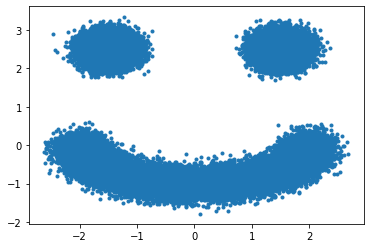

In [3]:
x, y = sample_data()
plt.scatter(x[:, 0], x[:, 1], marker='.')

x_train = x[:int(len(x) * 0.8)]
x_test = x[int(len(x) * 0.8):]

In [4]:
class TransNet(nn.Module):
    """
    Network that learns scale and bias parameters (s and t function in RealNVP paper).
    """
    def __init__(self, hidden_size=100, n_hidden = 1):
        super(TransNet, self).__init__()
        self.hidden_size = hidden_size
        self.n_hidden = n_hidden
        
        self.linears = nn.ModuleList()
        self.linears.append(nn.Linear(2, self.hidden_size))
        for i in range(n_hidden - 1):
            self.linears.append(nn.Linear(self.hidden_size, self.hidden_size))
        self.out_layer = nn.Linear(self.hidden_size, 2)
        
    def forward(self, x):
        h = x
        for linear in self.linears:
            h = F.relu(linear(h))
        out = self.out_layer(h)
        return out
    
    
class ActNorm(nn.Module):
    
    def __init__(self, feature_size):
        super(ActNorm, self).__init__()
        self.register_parameter("s", nn.Parameter(torch.ones([1, feature_size])))
        self.register_parameter("b", nn.Parameter(torch.zeros([1, feature_size])))
        
    def initialize(self, x):
        std = torch.std(x, dim=0, keepdim=True)
        self.s.data.copy_(1.0 / std)
        self.b.data.copy_(-torch.mean(x * self.s, dim=0, keepdim=True))
        
    def forward(self, x, reverse=False):
        if not reverse:
            logdet = torch.sum(torch.log(torch.abs(self.s) + 1e-6), dim=1, keepdim=True)
            out = x * self.s + self.b
            return out, logdet
        else:
            out = (x - self.b) / self.s
            return out

In [5]:
class CouplingLayer(nn.Module):
    
    def __init__(self, mask, hidden_size=100, n_hidden=1):
        super(CouplingLayer, self).__init__()
        self.register_buffer("mask", torch.ones([1, 2]).float())
        self.mask.data.copy_(mask.data)
        self.biasNet = TransNet(hidden_size, n_hidden)
        self.scaleNet = TransNet(hidden_size, n_hidden)
        
    def forward(self, x, reverse=False):
        if not reverse:
            z = self.mask * x
            scale = torch.tanh(self.scaleNet(self.mask * x))
            bias = self.biasNet(self.mask * x)
            z = z + (1.0 - self.mask) * (x * torch.exp(scale) + bias)
            logdet = torch.sum((1.0 - self.mask) * scale, dim=1, keepdim=True)
            return z, logdet
        else:
            z = self.mask * x
            scale = torch.tanh(self.scaleNet(self.mask * x))
            bias = self.biasNet(self.mask * x)
            z = z + (1.0 - self.mask) * (x - bias) * torch.exp(-scale)
            return z

In [6]:
class RealNVP(nn.Module):
    
    def __init__(self, n_layers=5, n_hidden=1):
        super(RealNVP, self).__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        mask = torch.ones([1, 2], dtype=torch.float64)
        mask[:, 0] = 0.0
        
        self.layers = nn.ModuleList()
        for i in range(self.n_layers):
            mask = 1.0 - mask
            self.layers.append(CouplingLayer(mask, n_hidden=self.n_hidden))
            if i != self.n_layers - 1:
                self.layers.append(ActNorm(2))
    
    def initialize(self, x):
        with torch.no_grad():
            for layer in self.layers:
                if (isinstance(layer, ActNorm)):
                    layer.initialize(x)
                x, _ = layer(x)
        
    def forward(self, x, reverse=False):
        if not reverse:
            logdet_sum = torch.zeros([x.shape[0], 1], dtype=torch.float32).cuda()
            for layer in self.layers:
                x, logdet = layer(x)
                logdet_sum = logdet_sum + logdet
            out = torch.sigmoid(x)
            logdet_sigmoid = torch.sum(torch.log(out * (1.0 - out) + 1e-6), dim=1, keepdim=True)
            logdet_sum = logdet_sum + logdet_sigmoid
            return out, logdet_sum
        else:
            z = - torch.log(1.0 / x - 1.0) # reverse sigmoid
            for layer in reversed(self.layers):
                z = layer(z, reverse=True)
            return z

In [7]:
batch_size = 125
n_epochs = 100
n_iter_per_epoch = x_train.shape[0] // batch_size
val_steps = n_iter_per_epoch // 8
lr = 5e-4
logs = {}

net = RealNVP(8, 3).cuda()
init_batch = torch.from_numpy(x_train).float().cuda()
net.initialize(init_batch)

opt = optim.Adam(net.parameters(), lr=lr)

train_log = []
val_log = []
global_step = 0

for epoch in range(n_epochs):
    idx = np.random.permutation(x_train.shape[0])
    for i in range(n_iter_per_epoch):
        global_step += 1

        batch = torch.from_numpy(x_train[idx[i * batch_size: (i + 1) * batch_size], :]).float().cuda()
        _, logdet = net(batch)

        loss = -torch.sum(logdet, dim=0)

        opt.zero_grad()
        loss.backward()
        opt.step()

#                     print("Epoch-{:d}/{:d} Iter-{:d}/{:d}: Loss-{:.5f}".format(epoch + 1, n_epochs, i + 1, n_iter_per_epoch, loss.item()))
        train_nll = loss.detach() / (batch_size * 2 * np.log(2))
        train_log.append(train_nll.item())

        # Validation
        if (global_step % val_steps == 0):
            _, logdet = net(torch.from_numpy(x_test).float().cuda()) 
            val_nll =  - torch.mean(logdet.detach()) / (2 * np.log(2))
            val_log.append(val_nll.item())

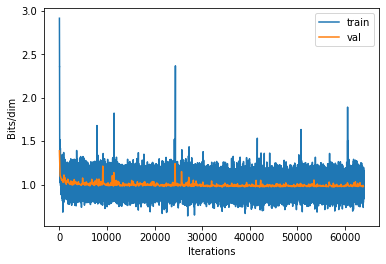

In [8]:
plt.plot(np.arange(len(train_log)), train_log, label="train")
plt.plot([i * 80 for i in np.arange(len(val_log))], val_log, label="val")
plt.xlabel("Iterations")
plt.ylabel("Bits/dim")
plt.legend()

In [9]:
z, logdet = net(torch.from_numpy(x_test).float().cuda()) 
val_nll =  - torch.mean(logdet.detach()) / (2 * np.log(2))
print("Test set performance: {:.5f} bits/dim".format(val_nll.item()))

Test set performance: 0.97772 bits/dim


### learned density over $(-4, 4)^2$

In [10]:
d = np.linspace(-4, 4, 100)
samples = np.array(np.meshgrid(d, d)).T.reshape([-1, 2])
samples = torch.from_numpy(samples).float().cuda()
z, logdet = net(samples)
pdf = torch.exp(logdet).cpu().data.numpy().reshape(100, 100)

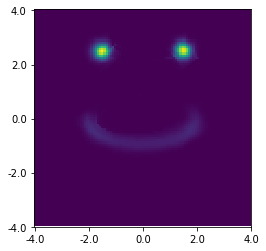

In [11]:
plt.imshow(np.rot90(pdf, 1))
_ = plt.xticks(np.linspace(0, 100, 5), np.linspace(-4, 4, 5))
_ = plt.yticks(np.linspace(0, 100, 5), np.linspace(4, -4, 5))

### Latents for data

In [12]:
z, _ = net(torch.from_numpy(x).float().cuda())
z = z.data.cpu().data.numpy()

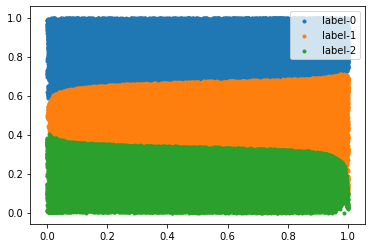

In [13]:
plt.figure()
plt.scatter(z[y == 0, 0], z[y == 0, 1], marker='.', label='label-0')
plt.scatter(z[y == 1, 0], z[y == 1, 1], marker='.', label='label-1')
plt.scatter(z[y == 2, 0], z[y == 2, 1], marker='.', label='label-2')
plt.legend(loc="upper right")

### Grid mapping

In [14]:
dx = np.linspace(-4, 4, 10)
dy = np.linspace(-4, 4, 1000)

In [15]:
grid_v = np.array(np.meshgrid(dx, dy)).T.reshape([-1, 2])
grid_h = np.array(np.meshgrid(dy, dx)).T.reshape([-1, 2])
grid = np.concatenate([grid_v, grid_h], axis=0)

In [16]:
mapped_grid, _ = net(torch.from_numpy(grid).float().cuda())
mapped_grid = mapped_grid.cpu().data.numpy()

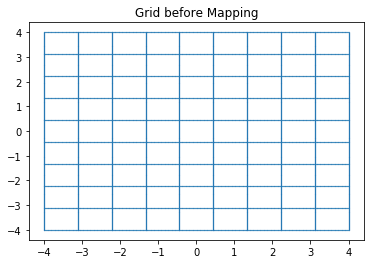

In [17]:
plt.scatter(grid[:, 0], grid[:, 1], marker='.', s=0.1)
_ = plt.title("Grid before Mapping")

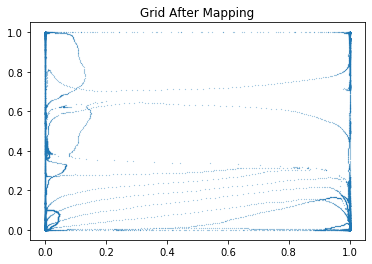

In [18]:
plt.scatter(mapped_grid[:, 0], mapped_grid[:, 1], marker='.', s=0.1)
_ = plt.title("Grid After Mapping")